<a href="https://colab.research.google.com/github/silverfuryK/Turbulence-Generation/blob/main/ACGAN_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.utils import save_image

import argparse
import os
import numpy as np
import math

#from params3tensor import *
import random


In [ ]:
data = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/data_chfirst.npy')
data_np = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/data_new_nonan.npy')
params_data = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/params_data_norm.npy')

data = torch.tensor(data)
params_data = torch.tensor(params_data[1:])
if torch.cuda.is_available():
    data = data.to(device = 'cuda', dtype=torch.float)
    print('cuda available')
    params_data = params_data.to(device = 'cuda', dtype=torch.float)
    

train_dataset = (data, params_data)
# train_loader = torch.utils.data.DataLoader(data,shuffle=True,   batch_size = 1)

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,   batch_size = 1)


cuda available


In [ ]:
# arguments
import sys
sys.argv=['']
del sys
os.makedirs("gan/images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=500, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=10, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=256, help="dimensionality of the latent space")
parser.add_argument("--n_params", type=int, default=9, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=64, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=4, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args()
print(opt)
cuda = True if torch.cuda.is_available() else False

img_shape = (opt.channels, opt.img_size, opt.img_size)

Namespace(b1=0.5, b2=0.999, batch_size=10, channels=4, img_size=64, latent_dim=256, lr=0.0002, n_cpu=8, n_epochs=500, n_params=9, sample_interval=400)


In [ ]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        #self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, momentum = 0.8))
            #layers.append(nn.LeakyReLU(1, inplace=True))
            layers.append(nn.PReLU(out_feat,init = 1))
            nn.Dropout(0.4),
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_params, 512, normalize=False),
            *block(512, 512),
            *block(512, 1024),
            *block(1024, 2048),
            #*block(1024, 1024),
            *block(2048, 4096),
            nn.Linear(4096, 64 * 16* 16),
            nn.PReLU( 64 * 16* 16)
        )

        def cnn_block(out_dim, in_feat, out_feat, upscale = False,  normalize=True):
            #layers = [nn.Upsample(size=(2*in_dim + 2,2*in_dim + 2 )),
            #          nn.Conv2d(in_feat, out_feat,3,1,0)]
            layers = [];
            
            if upscale:
                layers.append(nn.Upsample(size=(out_dim + 2, out_dim + 2)))
            layers.append(nn.Conv2d(in_feat, out_feat,3,1,0))
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, momentum = 0.8))
            layers.append(nn.PReLU(out_feat))

            if upscale:
                layers.append(nn.Upsample(size=(out_dim + 2, out_dim + 2)))
            layers.append(nn.Conv2d(out_feat, out_feat,3,1,0))
            '''if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.PReLU(out_feat))

            if upscale:
                layers.append(nn.Upsample(size=(out_dim + 4, out_dim + 4)))
            layers.append(nn.Conv2d(out_feat, out_feat,5,1,0))'''

            #if normalize:
            #    layers.append(nn.BatchNorm2d(out_feat, 0.8))
            #layers.append(nn.PReLU(out_feat,init = 1))

            #layers.append(nn.Conv2d(out_feat, out_feat,3,1,0))
            #layers.append(nn.PReLU(init = 1))

            #layers.append(nn.Conv2d(out_feat, out_feat,1,1,0))
            #layers.append(nn.PReLU(init = 1))     

            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, momentum = 0.8))
            #layers.append(nn.LeakyReLU(1, inplace=True))
            layers.append(nn.PReLU(out_feat))
            return layers

        self.cnn_tweak = nn.Sequential(
            #*cnn_block(256,256), # 4 > 8
            *cnn_block(32,64,256, upscale = True), # 8 > 16
            *cnn_block(64,256,256, upscale = True), # 16 > 32
            *cnn_block(64,256,128, upscale = True), # 16 > 32
            *cnn_block(64,128,4, upscale = True), # 32 > 64
            #nn.PReLU(init = 1)

        )

    def forward(self, noise, params):
        ## Concatenate label embedding and image to produce input
        gen_input = torch.cat((params, noise), -1)
        img = self.model(gen_input)
        #print(img.shape)
        img = img.view(img.shape[0], 64, opt.img_size // 4, opt.img_size // 4)
        img = self.cnn_tweak(img)
        #print(img.shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_params + int(np.prod(img_shape)), 4096),
            #nn.LeakyReLU(1, inplace=True),
            nn.PReLU(4096),
            nn.Linear(4096, 2048),
            nn.Dropout(0.4),
            #nn.LeakyReLU(1, inplace=True),
            nn.PReLU(2048),
            nn.Linear(2048, 1024),
            nn.Dropout(0.4),
            #nn.LeakyReLU(1, inplace=True),
            nn.PReLU(1024),
            nn.Linear(1024, 512),
            nn.Dropout(0.4),
            #nn.LeakyReLU(1, inplace=True),
            nn.PReLU(512),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, im_params):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), im_params), -1)
        validity = self.model(d_in)
        return validity



In [ ]:
#loss functions
adversarial_loss = torch.nn.MSELoss()

NameError: ignored

In [ ]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

In [ ]:


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
#generator.apply(weights_init_normal)
#discriminator.apply(weights_init_normal)

print(discriminator)
print(generator)

num_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters in Discriminator: %d' % num_params)
num_paramsE = sum(q.numel() for q in generator.parameters() if q.requires_grad)
print('Number of parameters in Generator: %d' % num_paramsE)

In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


In [ ]:
generator.train()
discriminator.train()
# ----------
#  Training
# ----------

bat = 5
dat_len = 600

for epoch in range(opt.n_epochs):
  i = 0
  ind = 0
  # batch loop
  mul = 0
  TlossG = torch.tensor(0).to('cuda', dtype=torch.float)
  TlossD = torch.tensor(0).to('cuda', dtype=torch.float)
  for dat in range(0,int((dat_len/bat))):

    #imgs = data[i]
    
    params = params_data[i]

    # Adversarial ground truths
    imgs = data[dat*bat:(dat+1)*bat]    
    imgs = imgs.to(device = 'cuda')
    imgs = imgs[:,0:4]
    batch_size = imgs.shape[0]
    
    valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
    

    params = params_data[dat*bat:(dat+1)*bat]

    # Configure input
    #real_imgs = Variable(imgs.type(Tensor))
    real_imgs = imgs
    # -----------------
    #  Train Generator
    # -----------------

    optimizer_G.zero_grad()

    # Sample noise as generator input
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
    #z = torch.cat((params, z), dim = -1)
    gen_params = Variable(LongTensor(np.random.randn(batch_size,opt.n_params)))

    # Generate a batch of images
    gen_imgs = generator(z, gen_params)

    # Loss measures generator's ability to fool the discriminator
    g_loss = adversarial_loss(discriminator(gen_imgs, gen_params), valid)

    g_loss.backward()
    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------

    optimizer_D.zero_grad()

    # Measure discriminator's ability to classify real from generated samples
    # loss for real
    validity_real = discriminator(imgs, params)
    d_loss_real = adversarial_loss(validity_real, valid)
    #loss for fake
    validity_fake = discriminator(gen_imgs.detach(), gen_params)
    d_loss_fake = adversarial_loss(validity_fake, fake)
    
    


    d_loss = (d_loss_real + d_loss_fake) / 2

    d_loss.backward()
    optimizer_D.step()
    TlossG = TlossG + abs(g_loss)
    TlossD = TlossD + abs(d_loss)

    batches_done = epoch * bat + dat
    
  TlossG = TlossG/(dat_len/bat)
  TlossD = TlossD/(dat_len/bat)
  print(
      "[Epoch %d/%d] [D loss avg: %f] [G loss avg: %f]"
      % (epoch, opt.n_epochs, TlossD.item(), TlossG.item())
  )
  #if epoch % opt.sample_interval == 0:
  #      save_image(gen_imgs.data[0,0:3], "gan/images/%d.png" % epoch, nrow = 5, normalize=True)
  

    



[Epoch 0/500] [D loss avg: 0.167724] [G loss avg: 0.552972]
[Epoch 1/500] [D loss avg: 0.140297] [G loss avg: 0.583848]
[Epoch 2/500] [D loss avg: 0.175583] [G loss avg: 0.570732]
[Epoch 3/500] [D loss avg: 0.151623] [G loss avg: 0.532811]
[Epoch 4/500] [D loss avg: 0.166945] [G loss avg: 0.576491]
[Epoch 5/500] [D loss avg: 0.157510] [G loss avg: 0.560998]
[Epoch 6/500] [D loss avg: 0.145249] [G loss avg: 0.613685]
[Epoch 7/500] [D loss avg: 0.153961] [G loss avg: 0.613362]
[Epoch 8/500] [D loss avg: 0.145068] [G loss avg: 0.552218]
[Epoch 9/500] [D loss avg: 0.158971] [G loss avg: 0.564588]
[Epoch 10/500] [D loss avg: 0.154849] [G loss avg: 0.569584]
[Epoch 11/500] [D loss avg: 0.141357] [G loss avg: 0.650728]
[Epoch 12/500] [D loss avg: 0.144817] [G loss avg: 0.582142]
[Epoch 13/500] [D loss avg: 0.143394] [G loss avg: 0.611611]
[Epoch 14/500] [D loss avg: 0.153483] [G loss avg: 0.578976]
[Epoch 15/500] [D loss avg: 0.164354] [G loss avg: 0.567396]
[Epoch 16/500] [D loss avg: 0.1444

KeyboardInterrupt: ignored

In [ ]:
z.shape

torch.Size([5, 64])

In [ ]:
gen_imgs.shape

torch.Size([5, 16, 64, 64])

In [ ]:
gen_params.shape

torch.Size([5, 9])

In [ ]:
valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)


In [ ]:
valid.shape

torch.Size([5, 1])

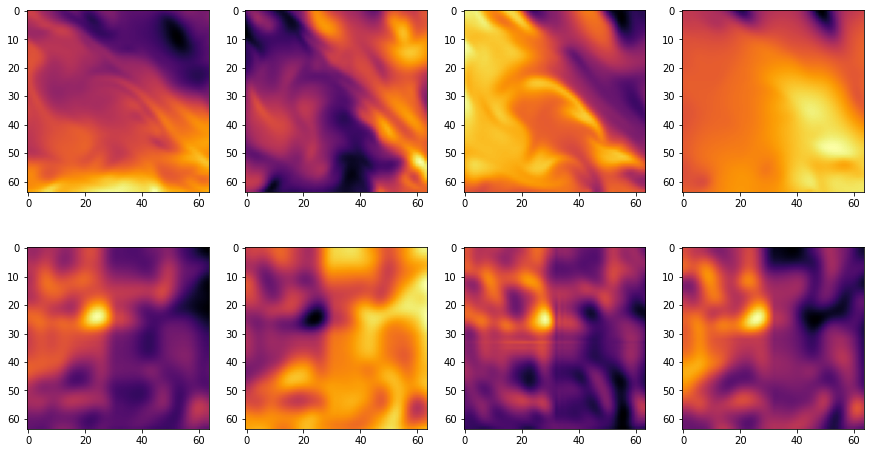

In [ ]:
sample = random.randint(0,600)
generator.eval()
para = params_data[sample]
para = torch.unsqueeze(para, 0)

test_img = data[sample]
test_img = torch.unsqueeze(test_img,0)

test_img = test_img.to(device = 'cpu')
test_img = test_img.detach().numpy()

ran_arr = np.random.normal(0, 1, (1, opt.latent_dim))
ran_arr = torch.tensor(ran_arr, dtype=torch.float).to(device = 'cuda')

gen_inp = torch.cat((para,ran_arr), -1)

gen = generator(ran_arr,para)

gen = gen.to(device='cpu').detach().numpy()

#plt.imshow(gen[0,0], cmap = 'inferno')
#plt.figure()
#plt.imshow(gen[0,1], cmap = 'inferno')
#plt.figure()
#plt.imshow(gen[0,2], cmap = 'inferno')
#plt.figure()
#plt.imshow(gen[0,3], cmap = 'inferno')
#plt.figure()

fig,a = plt.subplots(2,4,figsize=(15,8))
a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
a[1][0].imshow(gen[0,0,:,:], cmap='inferno')
a[1][1].imshow(gen[0,1,:,:], cmap='inferno')
a[1][2].imshow(gen[0,2,:,:], cmap='inferno')
a[1][3].imshow(gen[0,3,:,:], cmap='inferno')


In [ ]:
m = nn.PReLU(init = 1)
input = torch.randn(2)
ip = torch.tensor((0.15, -0.548))
m(ip)

tensor([ 0.1500, -0.5480])

In [ ]:
torch.save(generator.state_dict(), '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cgan2_v3_1_gen.pt')
torch.save(discriminator.state_dict(), '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cgan2_v3_1_dis.pt')

In [ ]:
generator.load_state_dict(torch.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cgan2_v3_gen.pt'))
discriminator.load_state_dict(torch.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cgan2_v3_dis.pt'))

<All keys matched successfully>